# Explaining Classifiers using Adversarial Perturbations on the Perceptual Ball
Andrew Elliott, Stephen Law and Chris Russell 

This notebook gives a simple example of running our explainability method on a single image.

Please note that without a GPU this notebook may take a little time to generate the resultant images.


In [2]:
# Loading libraries

# Image libraries and image processing functions
import torchvision
from scipy.ndimage import gaussian_filter
import numpy as np
import torch.nn.functional as F

# Our method code
from common_code.mul_perceptualFunc_Final import *
from common_code import utils

# Plotting libraries
import matplotlib.pyplot as plt

import piq


First we load the model, this can be changed to other VGG based variants, however the layers selected later would have to be changed to match the ReLUs in that network. To use with other networks a small change would be required in the feature extractor so it output the correct layers.

In [3]:
# Simple function wrapper
from functools import partial
def perceptual_dino(image_name,k=100,model=None,layerLists=['16', '19', '22', '25', '29', '32'],sa=1,ga=10000, ds=100, img_size=(952, 952), patch_size=14, targetID=None):
    '''
    perceptual function that returns a saliency map. 
    k = iterations
    layerLists = the layers to regularise with the perceptual loss
    ga = weight of perceptual loss 
    '''
    
    # If the model is not specified assume vgg19
    if model==None:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model.requires_grad=False
        model.eval()
    
    # load the image
    img_variable = utils.open_and_preprocess(image_name)
    img_dino = utils.open_and_preprocess_dino(image_name, img_size, patch_size)
    preprocess_dino = partial(utils.preprocess_dino, img_size=img_size, patch_size=patch_size)

    # Load onto GPU
    img_variable=img_variable.cuda()
    img_dino=img_dino.cuda()
    model=model.cuda()

    # create the perceptual loss with the required parameters
    # loss=create_perceptual_loss2(-2,img_variable,model,gamma=ga,scalar=sa,layers=layerLists)
    dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
    for p in dino_model.parameters():
        p.requires_grad = False
    dino_model.cuda()
    dino_model.eval()
    loss = create_perceptual_loss_dino(-2, preprocess_dino, img_variable, img_dino, model, dino_model, gamma=ga, scalar=sa, dino_scalar=ds, layers=layerLists, targetID=targetID)  

    # optimise the loss to find the adv. perturbation
    c=find_direction(loss,img_variable,iterations=k)
 
    # Take pixelwise euclidean distance to get the saliency map
    res=torch.sqrt(((c - img_variable)**2).mean(1))
    res=res.squeeze().cpu().detach().numpy()
    return c, res

def perceptual(image_name,k=100,model=None,layerLists=['16', '19', '22', '25', '29', '32'],sa=1,ga=10000):
    '''
    perceptual function that returns a saliency map. 
    k = iterations
    layerLists = the layers to regularise with the perceptual loss
    ga = weight of perceptual loss 
    '''
    
    # If the model is not specified assume vgg19
    if model==None:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model.requires_grad=False
        model.eval()
    
    # load the image
    img_variable = utils.open_and_preprocess(image_name)

    # Load onto GPU
    img_variable=img_variable.cuda()
    model=model.cuda()
    # create the perceptual loss with the required parameters
    loss=create_perceptual_loss2(-2,img_variable,model,gamma=ga,scalar=sa,layers=layerLists)

    # optimise the loss to find the adv. perturbation
    c=find_direction(loss,img_variable,iterations=k)
 
    # Take pixelwise euclidean distance to get the saliency map
    res=torch.sqrt(((c - img_variable)**2).mean(1))
    res=res.squeeze().cpu().detach().numpy()
    return c, res


We will demonstrate the method on the image in Fig. 2 in the paper. First lets specify our model, we will use a standard VGG19bn pretrained model from torchvision

In [4]:
# Load the relevant model
premodel = torchvision.models.vgg19_bn(pretrained=True)
premodel.requires_grad=False
premodel.eval()


/home/daniel/miniconda3/envs/perball/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/miniconda3/envs/perball/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

We specify the layers of the network that correspond to ReLus so we can regularise the correct layers. Note we include 

In [5]:
# layers list for VGG19_BN
layerAll=['2','5','9','12','16','19','22','25','29','32','35','38','42','45','48','51']


Next, lets specify our image. As a demonstration we will use the image from figure in our paper which we display below:

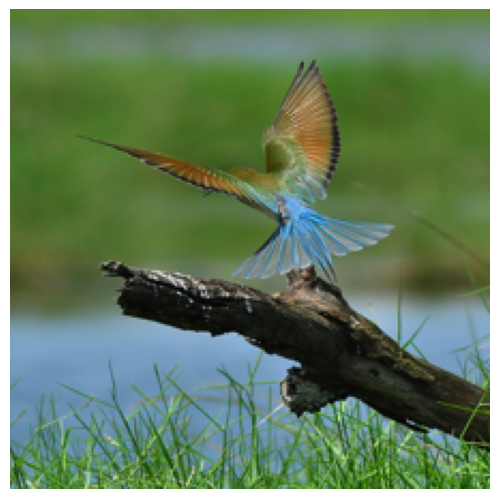

In [6]:
# image name
img='ILSVRC2012_val_00000051.JPEG'
im = utils.open_and_resize(img)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(im)
plt.show()

Next lets explore the saliency map regularizing on all layers, on CPU this may take a little while to run. To run on GPU, both the model and the image need to be on GPU above.

In [7]:
# # layers to regularise
# layerslist=["0-1-2-3-4-5-6-7-8-9-10-11-12"]

# # get layers
# # indexes layerAll
# layers=[layerAll[int(k)] for k in layerslist[0].split('-')]

# # run adversarial perturbation on the perceptual ball
# adv, res = perceptual_dino(img,k=500,model=premodel,layerLists=layers,sa=0,ga=0, ds=1000, targetID=94)

# # gaussian blur on image
# mat1 = gaussian_filter(res, sigma=2)

# # un-normalise
# aim = adv[0].cpu().detach().numpy().transpose(1,2,0)
# aim = (aim - aim.min())/(aim.max()-aim.min())
# aim = (aim*255).astype(np.uint8)

# # Plot saliency map and adversarial perturbation
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(mat1.squeeze())
# ax[0].set_title('Saliency map')
# ax[0].axis('off')
# ax[1].imshow(aim)
# ax[1].set_title('Adversarial perturbation')
# ax[1].axis('off')
# plt.show()

In [8]:
img_variable = utils.open_and_preprocess(img)
print(f"min, max: {img_variable.min()}, {img_variable.max()}")
premodel = premodel.cuda()
response = premodel(img_variable.cuda())
target_response = response[0, 94].item()
print(f"Target response: {target_response}")
# max
response[0, 92].item()

min, max: -2.1179039478302, 2.465708017349243
Target response: 10.466181755065918


14.855831146240234

In [9]:
# response = premodel(adv.cuda())
# target_response = response[0, 94].item()
# print(f"Target response: {target_response}")
# # max
# response[0, 92].item()

In [10]:
image_size = (952, 952)
patch_size = 14
img_variable = utils.open_and_preprocess(img)
def diff_renorm(image):
    """Maps image back into [0,1]. Useful for visualising differences"""
    scale = 0.5/image.abs().max()
    image = image*scale
    image += 0.5
    return image

img_variable = diff_renorm(img_variable)

print(f"Shape: {img_variable.shape}, min, max: {img_variable.min()}, {img_variable.max()}")

Shape: torch.Size([1, 3, 224, 224]), min, max: 0.07052823901176453, 1.0


In [32]:
def generate_pgd_adversarial(image, model, target_class, epsilon=0.03, alpha=0.005, num_steps=40):
    """
    Generates a PGD adversarial image.
    
    Parameters:
    - image (torch.Tensor): The original image tensor of shape (1, C, H, W).
    - model (torch.nn.Module): The classifier model.
    - target_class (int): The target class index.
    - epsilon (float): Maximum perturbation magnitude.
    - alpha (float): Step size for each iteration.
    - num_steps (int): Number of steps to perform PGD.
    
    Returns:
    - torch.Tensor: The adversarial image.
    """
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Create a copy of the image and set it to require gradients
    adv_image = image.clone().detach().requires_grad_(True)
    
    for step in range(num_steps):
        # Forward pass
        # print(f"Step {step}")
        output = model(adv_image)
        loss = F.cross_entropy(output, torch.tensor([target_class], device=image.device))
        print(f"Step {step}, Loss: {loss.item()}")
        # Backward pass
        loss.backward()
        
        # Update the image with the gradient sign
        with torch.no_grad():
            adv_image -= alpha * adv_image.grad.sign()
            
            # Project the perturbation
            perturbation = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
            adv_image = torch.clamp(image + perturbation, 0, 1).detach()
            adv_image.requires_grad_(True)
            # print(f"Adv grad: {adv_image.grad}")
        
        # Check if adv_image.grad is not None before zeroing
        if adv_image.grad is not None:
            print(f"Step {step}")
            adv_image.grad.zero_()

    res=torch.sqrt(((adv_image - image)**2).mean(1))
    res=res.squeeze().cpu().detach().numpy()

    print(f"Shape: {res.shape} and {adv_image.shape}")
    return adv_image, res

adv_image, res = generate_pgd_adversarial(img_variable.cuda(), premodel.cuda(), 18, epsilon=0.03, alpha=0.005, num_steps=40)

Step 0, Loss: 8.975605010986328
Step 1, Loss: 3.3212618827819824
Step 2, Loss: 0.6185246109962463
Step 3, Loss: 0.15266743302345276
Step 4, Loss: 0.12569260597229004
Step 5, Loss: 0.006834345404058695
Step 6, Loss: 0.000626367807853967
Step 7, Loss: 1.4305104514278355e-06
Step 8, Loss: 5.960462772236497e-07
Step 9, Loss: 0.0
Step 10, Loss: 0.004842102527618408
Step 11, Loss: 8.344646857949556e-07
Step 12, Loss: 1.1920928244535389e-07
Step 13, Loss: 0.0
Step 14, Loss: 0.00010644822759786621
Step 15, Loss: 0.0
Step 16, Loss: 8.105902816168964e-05
Step 17, Loss: 0.0
Step 18, Loss: 0.025223946198821068
Step 19, Loss: 3.576278118089249e-07
Step 20, Loss: 0.0
Step 21, Loss: 0.0009575072908774018
Step 22, Loss: 1.1920928244535389e-07
Step 23, Loss: 0.0
Step 24, Loss: 0.005122157279402018
Step 25, Loss: 0.0
Step 26, Loss: 0.0008459088858217001
Step 27, Loss: 1.1920928244535389e-07
Step 28, Loss: 0.0
Step 29, Loss: 0.0010026433737948537
Step 30, Loss: 0.0
Step 31, Loss: 0.00020811776630580425
S

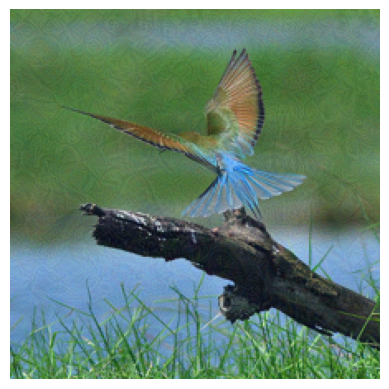

In [36]:
premodel(adv_image.cuda())[0, 18].item(), premodel(img_variable.cuda())[0, 18].item()
# Save adv image as "adv_image.png"
adv_image = adv_image.cpu().detach().numpy().squeeze().transpose(1, 2, 0)
adv_image = (adv_image - adv_image.min())/(adv_image.max()-adv_image.min())
adv_image = (adv_image*255).astype(np.uint8)
plt.imshow(adv_image)
plt.axis('off')
plt.show()
plt.imsave("adv_image.png", adv_image)


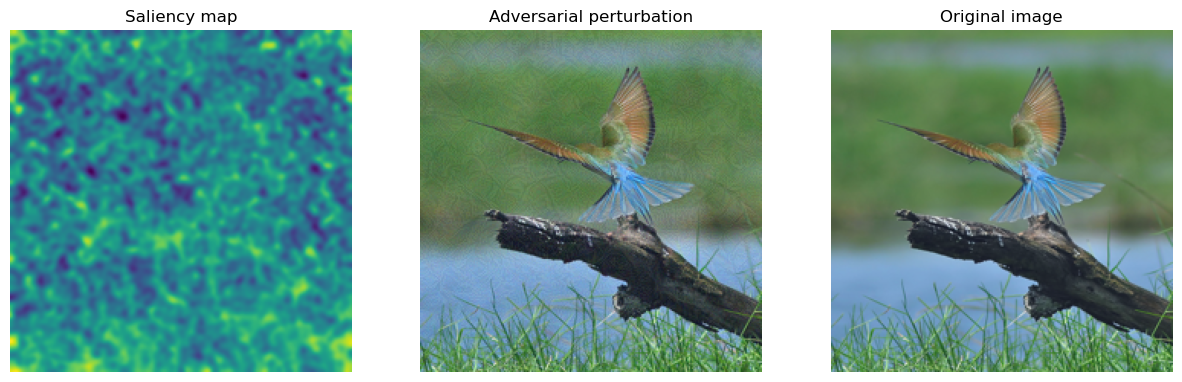

In [35]:
mat1 = gaussian_filter(res, sigma=2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mat1.squeeze())
ax[0].set_title('Saliency map')
ax[0].axis('off')
ax[1].imshow(adv_image[0].cpu().detach().numpy().transpose(1,2,0))
ax[1].set_title('Adversarial perturbation')
ax[1].axis('off')
# Salt and pepper noise

noised = img_variable + torch.randn_like(img_variable)*0.1

ax[2].imshow(img_variable[0].cpu().detach().numpy().transpose(1,2,0))
ax[2].set_title('Original image')
ax[2].axis('off')
plt.show()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_dinov2_main
/home/daniel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/daniel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/daniel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


L2 distance: 12.617518424987793


In [49]:

# get the features
with torch.no_grad():
    noised_img = img_variable + torch.randn_like(img_variable)*0.1
    features = model.forward_features(img_variable.to(device))
    noised_feats = model.forward_features(noised_img.to(device))
    adv_features = model.forward_features(adv_image.to(device))
clstoken = features['x_norm_clstoken']
adv_clstoken = adv_features['x_norm_clstoken']
noised_cls = noised_feats['x_norm_clstoken']

# L2 distance
l2_dist = torch.norm(clstoken - adv_clstoken, p=2)
l2_dist_blur = torch.norm(clstoken - noised_cls, p=2)
print(f"L2 distance: {l2_dist.item()}")
print(f"L2 distance (noised): {l2_dist_blur.item()}")

L2 distance: 17.834484100341797
L2 distance (noised): 29.67685890197754


In [52]:
out_image = utils.open_and_preprocess('./results/out_100.png')
print(f"min, max: {out_image.min()}, {out_image.max()}")
print(f"Shape: {out_image.shape}")
# Show
# fig = plt.figure(figsize=(5,5))
# plt.imshow(out_image)
# plt.axis('off')

with torch.no_grad():
    out_features = model.forward_features(out_image.to(device))
out_clstoken = out_features['x_norm_clstoken']
l2_dist_out = torch.norm(clstoken - out_clstoken, p=2)
print(f"L2 distance (out): {l2_dist_out.item()}")

min, max: -1.741159439086914, 2.640000104904175
Shape: torch.Size([1, 3, 224, 224])
L2 distance (out): 24.156766891479492


In [54]:
# Generate a gray image (256, 256)
gray_image = torch.ones((1, 3, 256, 256), device=device)*0.5
# Save the image
plt.imsave('gray_image.png', gray_image[0].cpu().detach().numpy().transpose(1,2,0))

Finally, we run this on all of the layer sets in the paper.

We first make all of the images for each collection of layers. Note that this might take a while, expecially on CPU.

To make this runable by a wide audience we have reduced the number of LBFGS iterations and pushed the computation to CPU, which might result in slightly different results. 

In [9]:
layerslists = []
layerslists.append("")
layerslists.append("0-1-2")
layerslists.append("0-1-2-3-4")
layerslists.append("0-1-2-3-4-5-6")
layerslists.append("0-1-2-3-4-5-6-7-8-9-10-11-12")

images = []
for layerslist in layerslists:
    if len(layerslist)>0:
        layers = [layerAll[int(k)] for k in layerslist.split('-')]
    else:
        layers = []
    res = perceptual(img,k=100,model=premodel,layerLists=layers,sa=1,ga=10000)

    # gaussian blur on image
    mat1 = gaussian_filter(res, sigma=2)
    images.append(mat1)

Plot the resultant perturbations to obtain the similar plot to the version in the paper.

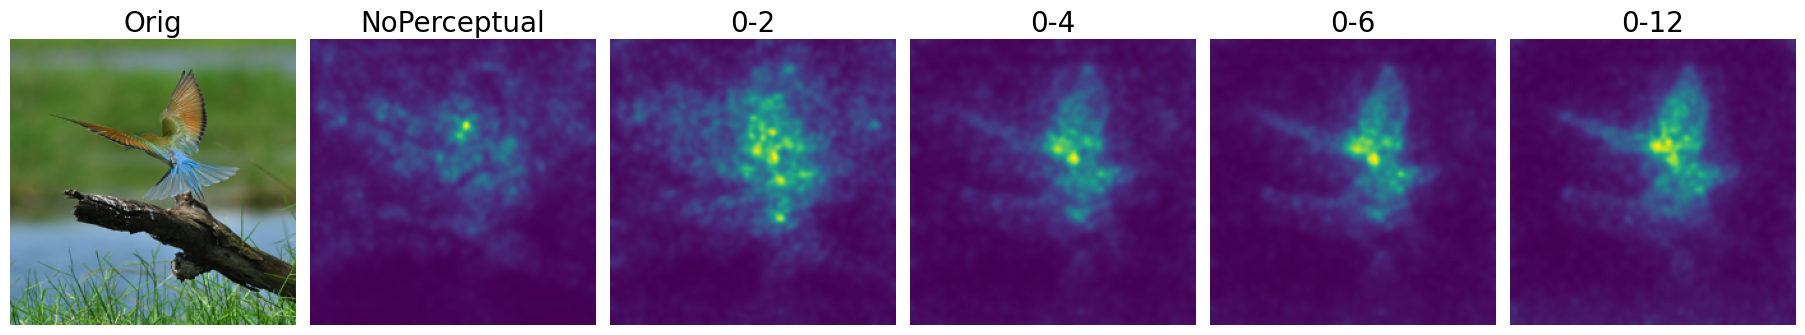

In [10]:
fig,axs = plt.subplots(1,6,figsize=(18,3))
titles = ['Orig']
titles.append("NoPerceptual")
titles.append("0-2")
titles.append("0-4")
titles.append("0-6")
titles.append("0-12")

for ax,curIm,title in zip(axs,[im,]+images,titles):
    ax.set_axis_off()
    ax.imshow(curIm)
    ax.set_title(title,fontsize=20)
plt.tight_layout(pad=0)
plt.show()